In [1]:
# Useful starting lines
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def compute_mse(e):
    return 1 / 2 * np.mean(e ** 2)


def compute_mae(e):
    return np.mean(np.abs(e))


def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """

    # Calculate the MSE here
    return compute_mse(y - tx.dot(w))

# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    for idx_row, row in enumerate(grid_w0):
        for idx_col, col in enumerate(grid_w1):
            w = np.array([row, col])
            losses[idx_row, idx_col] = compute_loss(y, tx, w)

    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678197, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.002 seconds


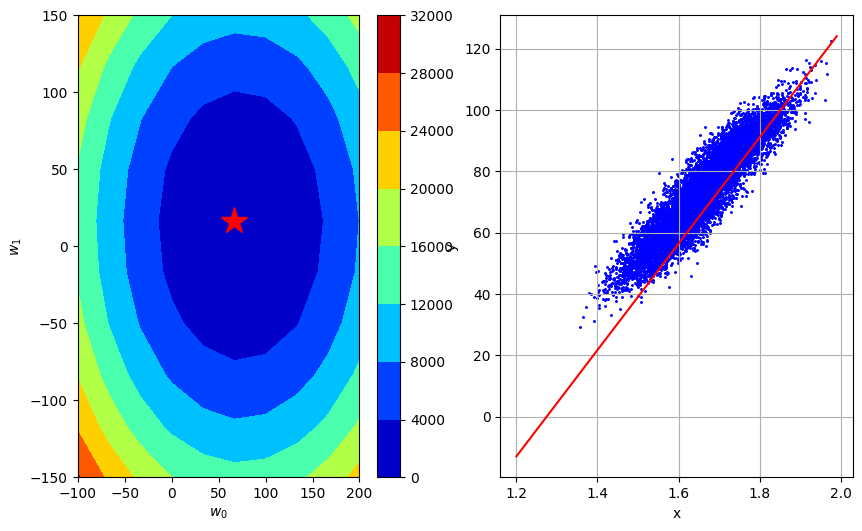

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [7]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # compute gradient vector

    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

Please fill in the functions `gradient_descent` below:

In [8]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss

        grad, err = compute_gradient(y, tx, w)
        loss = compute_mse(err)

        # update w by gradient
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [9]:
from IPython.display import clear_output, display

def gradient_descent_visualize(y, tx, initial_w, max_iters, gamma):
    """Gradient descent with dynamic visualization."""
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        grad, err = compute_gradient(y, tx, w)
        loss = compute_mse(err)

        # update w by gradient
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        
        # Visualization
        clear_output(wait=True)
        fig = gradient_descent_visualization(
            losses, ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter
        )
        display(fig)
        plt.close(fig) 
        
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [10]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759167, w0=51.30574540147367, w1=9.435798704492523
GD iter. 1/49: loss=265.30246210895723, w0=66.69746902191574, w1=12.266538315840142
GD iter. 2/49: loss=37.878379550440535, w0=71.31498610804832, w1=13.115760199244393
GD iter. 3/49: loss=17.410212120174382, w0=72.7002412338881, w1=13.370526764265657
GD iter. 4/49: loss=15.568077051450443, w0=73.11581777164001, w1=13.446956733772032
GD iter. 5/49: loss=15.402284895265295, w0=73.2404907329656, w1=13.469885724623945
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136326, w1=13.476764421879517
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788256, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783836, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.2934892088251, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412111, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305070992, w1=13.479705271317192
G

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [12]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # implement stochastic gradient computation. It's the same as the usual gradient.
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # implement stochastic gradient descent.
        for y_batch, tx_batch in batch_iter(y, tx, batch_size):

            grad, _ = compute_gradient(y_batch, tx_batch, w)
            w = w - gamma * grad
            ws.append(w)

            loss = compute_loss(y, tx, w)
            losses.append(loss)

            print(
                "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )
    return losses, ws

In [13]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2287.872870583787, w0=7.11770937852368, w1=0.6079274683090563
SGD iter. 1/49: loss=2007.469315212548, w0=12.71944463867273, w1=-4.265696741314717
SGD iter. 2/49: loss=1632.2944958812084, w0=19.498644568257838, w1=-4.956267111543108
SGD iter. 3/49: loss=1275.6004164152218, w0=25.71395972933232, w1=-2.5382851681539806
SGD iter. 4/49: loss=996.2511043030869, w0=31.40114615086516, w1=-0.8982486286067228
SGD iter. 5/49: loss=802.1516873580234, w0=35.78674923436041, w1=0.5667890653978835
SGD iter. 6/49: loss=587.1725547034644, w0=40.66071380609666, w1=4.611394865955251
SGD iter. 7/49: loss=432.5816530336592, w0=44.98778357528914, w1=7.721756400805555
SGD iter. 8/49: loss=346.5156141022306, w0=48.33578781530612, w1=7.206675659986379
SGD iter. 9/49: loss=314.222078645176, w0=50.36475553506842, w1=4.998809966524308
SGD iter. 10/49: loss=273.9260391980985, w0=52.23692405787569, w1=4.895824024993598
SGD iter. 11/49: loss=229.99740850165327, w0=54.349397910483134, w1=5.0935304

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [15]:
import datetime
from helpers import *

# reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [16]:
y.shape, tx.shape

((202,), (202, 2))

In [17]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()


#  fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#  and the model fit
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.84746409844847, w1=7.724426406192431
GD iter. 1/49: loss=318.2821247015953, w0=67.401703327983, w1=10.041754328050118
GD iter. 2/49: loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607415
GD iter. 3/49: loss=67.97477639885521, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631794
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.034889001593537
GD iter.

In [21]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

NotImplementedError: 

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))